In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import data_manager as dm
from PIL import Image
from skimage import filters

In [2]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from tqdm import tqdm
from skimage.segmentation import watershed, random_walker
from skimage.morphology import disk, ball
FIG_SIZE = (7, 7)

In [3]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [4]:
from matplotlib.colors import hsv_to_rgb

In [5]:
from scipy.ndimage.morphology import (distance_transform_edt, binary_fill_holes,
                binary_closing, binary_opening, binary_dilation, binary_erosion)
from scipy.signal import fftconvolve

In [6]:
data_folderes = ['/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_02026.tiff',
                 '/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_01960.tiff',
                 '/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_00949.tiff',
                 '/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_00355.tiff']

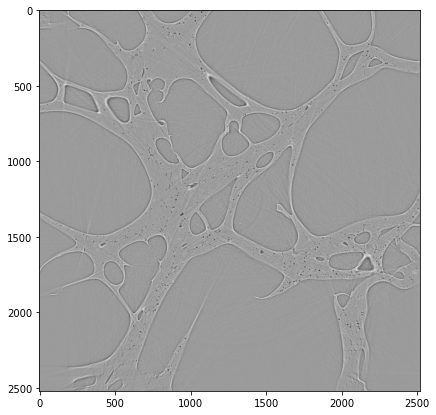

In [7]:

df_number = 1
df = Path(data_folderes[df_number])
img = np.array(Image.open(df))
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.imshow(img, cmap='gray')

In [8]:
def filter(img, ):
    kernel_size = 10
    kernel_shape = np.ones(img.ndim, dtype=int) * kernel_size
    kernel = np.ones(kernel_shape, dtype=int)
    # kernel = kernel / np.sum(kernel)
    return fftconvolve(img, kernel, mode='same')

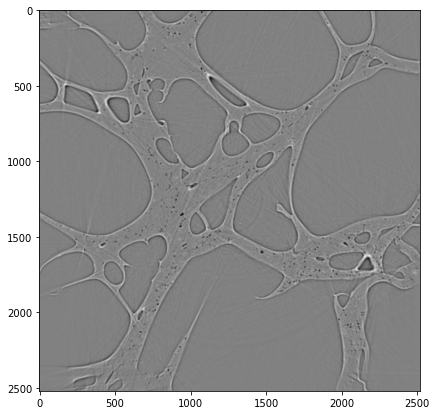

In [9]:
img = filter(img)

fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img, cmap='gray')

In [10]:
def plot_hist(img, ax, x_min=None, x_max=None):
    gray_volume = np.copy(img)
    if x_min:
        gray_volume_min = x_min
    else:
        gray_volume_min = np.min(gray_volume)

    if x_max:
        gray_volume_x_max = x_max
    else:
        gray_volume_max = np.max(gray_volume)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.hist(gray_volume.ravel(),
            bins=np.linspace(gray_volume_min, gray_volume_max, 255))
    ax.grid()

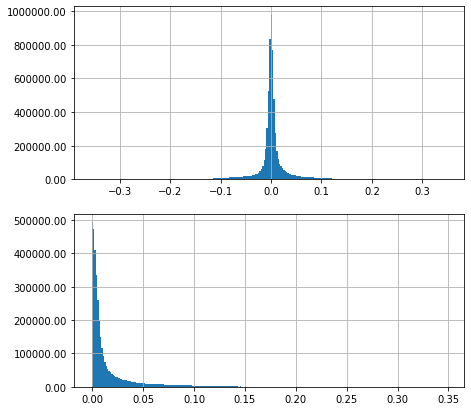

In [11]:
fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE)
plot_hist(img, ax[0])
plot_hist(img, ax[1], x_min=-0.00075)

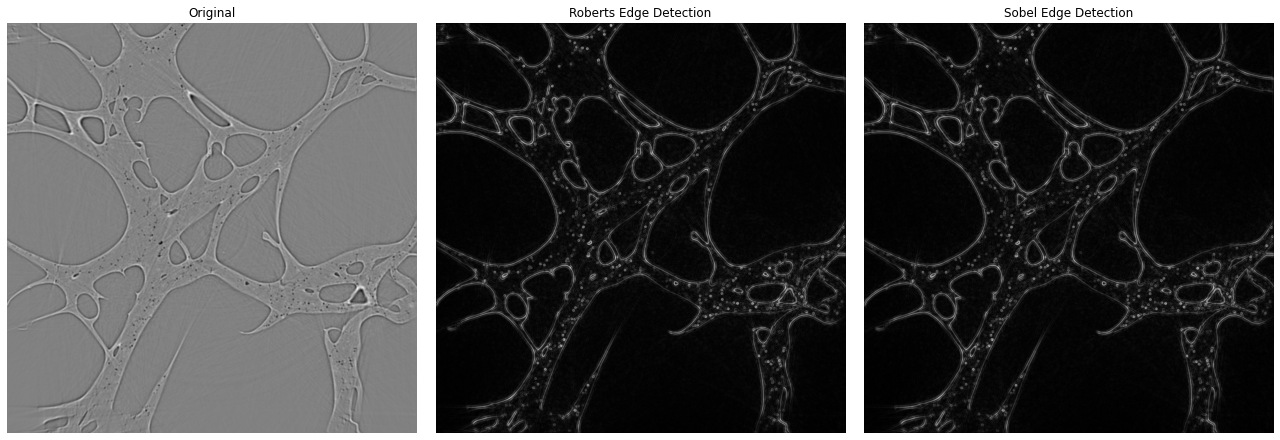

In [12]:

edge_roberts = filters.roberts(img)
edge_sobel = filters.sobel(img)

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True,
                         figsize=(18, 6))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Original')

axes[1].imshow(edge_roberts, cmap=plt.cm.gray)
axes[1].set_title('Roberts Edge Detection')

axes[2].imshow(edge_sobel, cmap=plt.cm.gray)
axes[2].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [166]:
center = np.asarray(img.shape) // 2
dx = dy =100

def calc_gradient(img):
    gradients = []
    for i in range(img.ndim):
        y = np.array([[0] for _ in range(img.shape[abs(1-i)])])
        if i == 0:
            y = np.transpose(y)
        print(img.shape, y.shape)
        
        print('img before:', img.shape)
        img_widened = np.append(img, y, axis=i)
        print('img after:', img_widened.shape)
        g = np.diff(img_widened, axis = i)
        gradients.append(g)
    print(len(gradients[0]), len(gradients[1]))
    return np.sqrt(gradients[0]*gradients[0] + gradients[1]*gradients[1]), np.arctan2(gradients[1], gradients[0])

def apply_gradients(img, ax, vector_length=5):
    X, Y = np.meshgrid(np.arange(0, img.shape[0]-1), np.arange(0, img.shape[1]-1))
    print(X.shape, Y.shape)
    gradients = calc_gradient(img)
    print(gradients[0][:,:-1].shape, gradients[1][:-1,:].shape)
    U = gradients[0][:,:-1][::vector_length, ::vector_length] / vector_length
    V = gradients[1][:-1,:][::vector_length, ::vector_length] / vector_length
    colors = np.arctan2(U, V)
    Q =  ax.quiver(X[::vector_length, ::vector_length],# * vector_length,
                   Y[::vector_length, ::vector_length],# * vector_length,
                   U,
                   V, 
                   colors,
                   units='width')
    

In [136]:
t = np.asarray([[1,2,3,4,5], [1,2,3,4,5]])

In [139]:
np.diff(t, axis = 1)

array([[1, 1, 1, 1],
       [1, 1, 1, 1]])

In [140]:
np.diff(t, axis = 0)

array([[0, 0, 0, 0, 0]])

In [133]:
np.zeros(np.transpose(t).shape[i])

array([0., 0., 0., 0., 0.])

In [134]:
t = np.asarray([[1,2,3,4,5], [1,2,3,4,5]])
i=0
y = np.array([[0] for _ in range(t.shape[abs(1-i)])])
if i == 0:
    y = np.transpose(y)
np.append(t, y, axis=i)

array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [0, 0, 0, 0, 0]])

In [155]:
np.diff([0,0,1,0,0,0,0,1,0,0])

array([ 0,  1, -1,  0,  0,  0,  1, -1,  0])

In [17]:
def plot_colored_graph(H, V, brightness=2):
    S = np.ones_like(V)
    #V=(V-V.min())/(V.max()-V.min())

    h=(H-H.min())/(H.max()-H.min())

    v = V/(2*np.pi)
    HSV = np.dstack((v,S,h*brightness))
    RGB = hsv_to_rgb(HSV)

    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(RGB)
    plt.colorbar()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


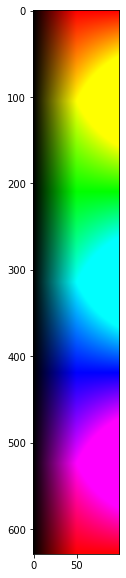

In [15]:
X, Y = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 2*np.pi, 0.01))
plot_colored_graph(X, Y)

In [148]:
x = [[0,0,0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0,0,0],
     [0,0,1,1,1,1,1,1,1,1,0,0],
     [0,0,1,0,0,0,0,0,0,1,0,0],
     [0,0,1,0,0,0,0,0,0,1,0,0],
     [0,0,1,0,0,0,0,0,0,1,0,0],
     [0,0,1,0,0,0,0,0,0,1,0,0],
     [0,0,1,0,0,0,0,0,0,1,0,0],
     [0,0,1,0,0,0,0,0,0,1,0,0],
     [0,0,1,1,1,1,1,1,1,1,0,0],
     [0,0,0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0,0,0]]
x = np.asarray(x)

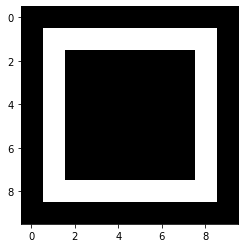

In [27]:
plt.imshow(x, cmap='gray')

(2520, 2520) (1, 2520)
img before: (2520, 2520)
img after: (2521, 2520)
(2520, 2520) (2520, 1)
img before: (2520, 2520)
img after: (2520, 2521)
2520 2520
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


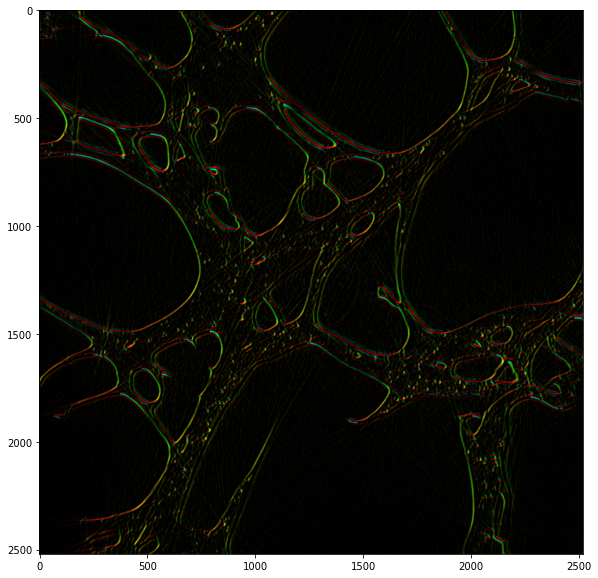

In [167]:
plot_colored_graph(*calc_gradient(img), brightness=2)

(2520, 2520) (1, 2520)
img before: (2520, 2520)
img after: (2521, 2520)
(2520, 2520) (2520, 1)
img before: (2520, 2520)
img after: (2520, 2521)
2520 2520
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


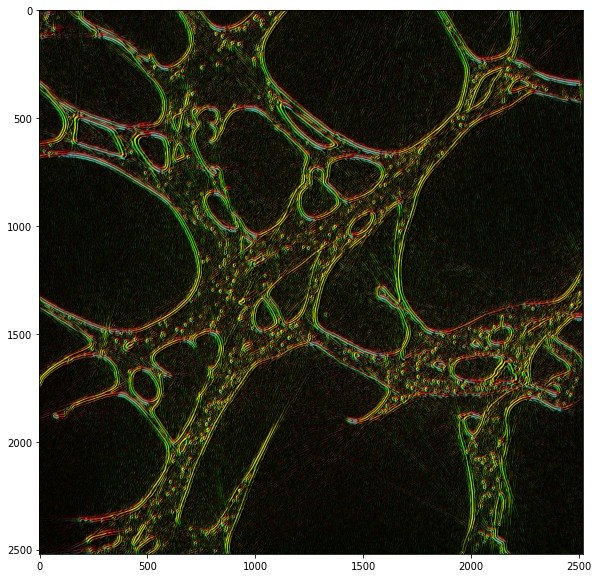

In [168]:
plot_colored_graph(*calc_gradient(edge_sobel), brightness=10)

# WALKERS

In [114]:
def create_mask(img):
    thrs1 = np.percentile(img.flat[::100], 90)
    # беру выборку из каждого 100-ого индекса массиво и ищу число, ниже которого 80% чисел выборки 
    thrs2 = np.percentile(img.flat[::100], 10)
    # беру выборку из каждого 100-ого индекса массиво и ищу число, ниже которого 10% чисел выборки
    
    need_squeeze = False
    if img.ndim == 2:
        need_squeeze = True
        img = img[np.newaxis,:,:]
        # добавили еще 1 измерение к 2мерному изображению(если оно было)
    
    # markers = np.zeros_like(img, dtype=np.uint16)
    # markers[img > thrs1] = 1
    # markers[img < thrs2] = 2
    # t = random_walker(img.astype(np.float32), markers, 1)
    tt = np.zeros((3,img.shape[0],img.shape[1], img.shape[2]), dtype=np.uint16)
    for j in range(3):
        t = np.zeros_like(img, dtype=np.uint16)
        for i in tqdm(range(t.shape[j])):
            t_img = img.take(i,j)
            # для каждой оси 3д массива выбирается плоскость (перпендикулярный к направлению оси)
            markers = np.zeros_like(t_img, dtype=np.uint16)
            markers[t_img > thrs1] = 1
            markers[t_img < thrs2] = 2
            # для этой плоскости создается маска, с элементами, которые превышают (вниз или вверх) пороговые значения 
            # (верочтно, пора или материал)
            rt = random_walker(t_img, markers, beta=1)
            # запускаяем random_walker с позиций маркеров и сегментируем
            if j==0:
                t[i] = rt
            elif j==1:
                t[:,i,:] = rt
            elif j==2:
                t[:,:,i] = rt
            # вставили плоскость назад в изображение(в этом цикле все по одной оси для каждой ее насечки)
        if need_squeeze:
            t = np.squeeze(t)
            # убираем 1-мерные размерности в массивах
            
        tt[j]=t
        #собираем все плоскости сегментации в одну кучу. Получаем 4д массив
    return tt      

In [115]:
mask_vanila = create_mask(edge_sobel)-1
mask_mean = np.median(mask_vanila, axis=0)

100%|██████████| 2520/2520 [00:09<00:00, 269.21it/s]


In [116]:
mask_mean = mask_mean[0]

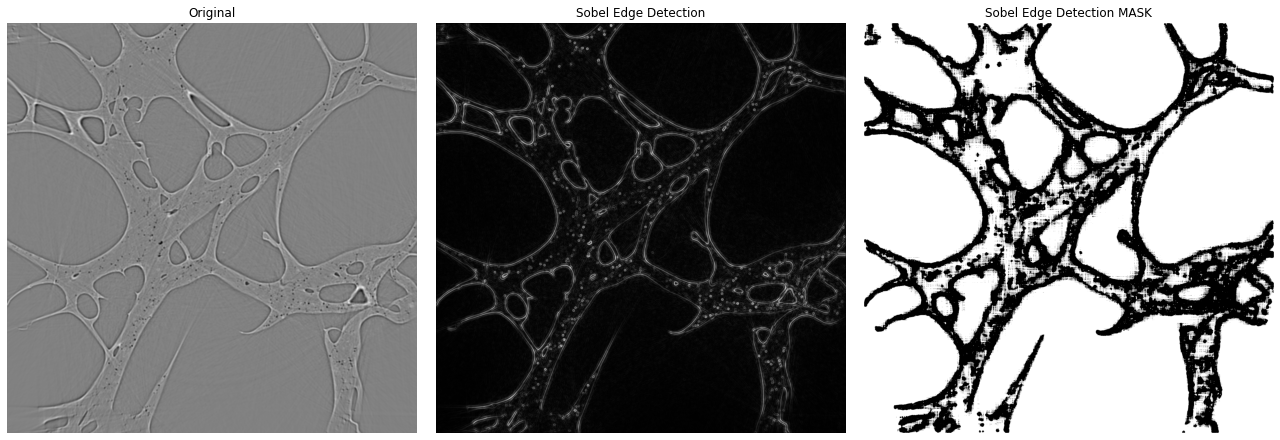

In [117]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True,
                         figsize=(18, 6))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Original')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

axes[2].imshow(mask_mean, cmap=plt.cm.gray)
axes[2].set_title('Sobel Edge Detection MASK')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

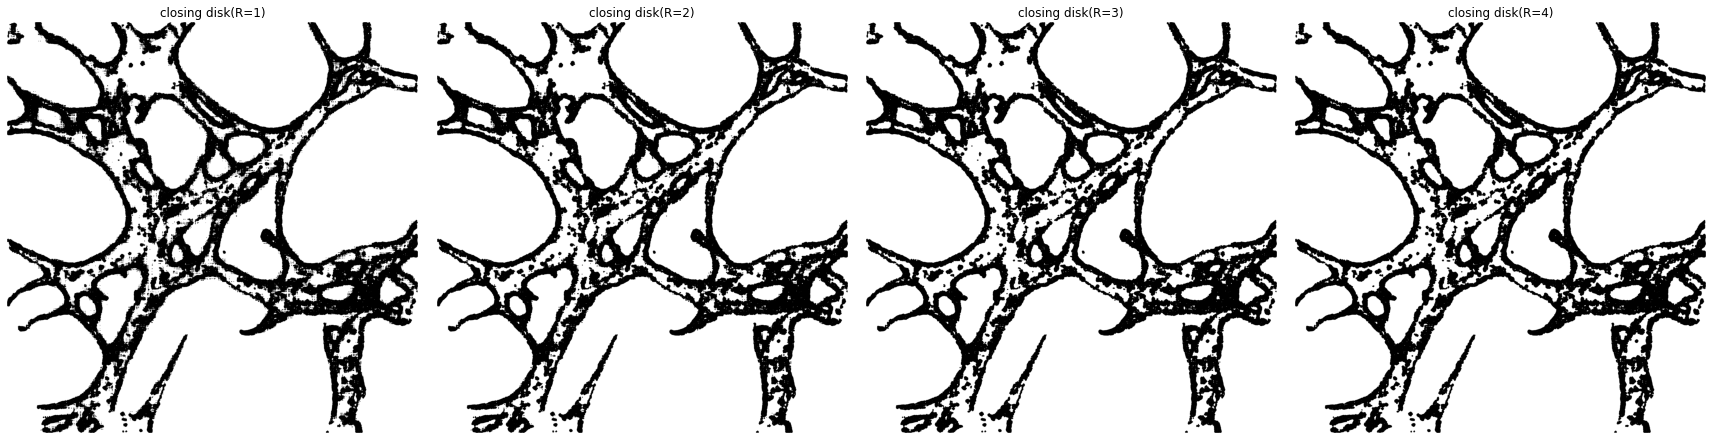

In [118]:
disc_radii=[1, 2, 3, 4]

number_of_plots = len(disc_radii)
fig, axes = plt.subplots(ncols=number_of_plots, figsize=(6*number_of_plots, 6))

for ax, r_disk in zip(axes, disc_radii):
    mask_no_stones = binary_closing(mask_mean, disk(r_disk), border_value=1)
    ax.imshow(mask_no_stones, cmap=plt.cm.gray)
    ax.set_title(f'closing disk(R={r_disk})')
    ax.axis('off')
plt.tight_layout()

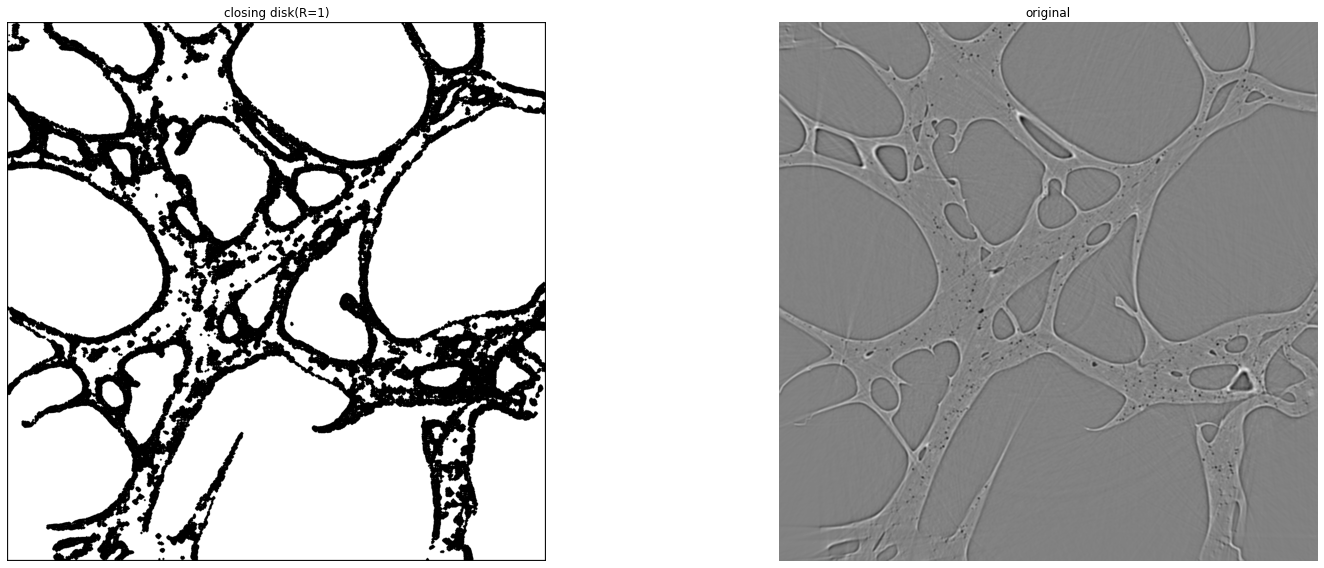

In [119]:
r_disk = 1

number_of_plots = len(disc_radii)
fig, axes = plt.subplots(ncols=2, figsize=(24, 8), sharex=True, sharey=True)
mask_no_stones = binary_closing(mask_mean, disk(r_disk), iterations=5)

axes[0].imshow(mask_no_stones, cmap=plt.cm.gray)
axes[0].set_title(f'closing disk(R={r_disk})')
axes[1].imshow(img, cmap=plt.cm.gray)
axes[1].set_title(f'original')

for ax in axes:
    ax.axis('off')
plt.tight_layout()

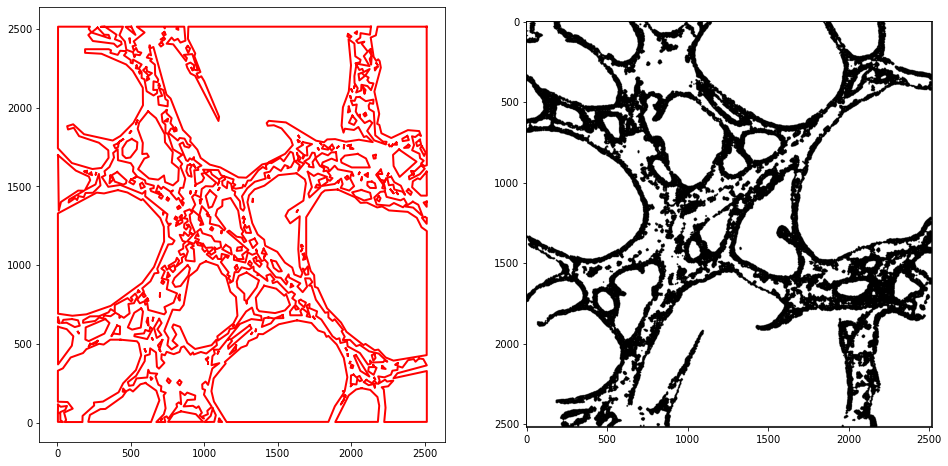

In [120]:
import matplotlib.pyplot as plt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

# create two ellipses in image
img = np.copy(mask_no_stones)

plt.gray()
ax2.imshow(img)

# approximate / simplify coordinates of the two ellipses
for contour in find_contours(img, 0):
    coords = approximate_polygon(contour, tolerance=10)
    ax1.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)

ax2.imshow(mask_no_stones, cmap=plt.cm.gray)

plt.show()